In [7]:
#test277 BB123789
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage 
import urllib
import os
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.gridspec as gridspec
from numpy import percentile
import gc

def extractFrame(mp4DIR,frmID):
    vid = cv2.VideoCapture(mp4DIR)
    i=0
    while vid.isOpened():
        ret,frame = vid.read()
        if ret:
            if i == frmID:
                return frame
        else:
            break
        i+=1; frame = None
def extractRedGreenBlue(frame):
    tmp = frame
    hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv,(36,0,0),(86,255,255))
    imask = mask>0
    green = np.zeros_like(tmp,np.uint8)
    green[imask] = tmp[imask]
    
    maskR1 = cv2.inRange(hsv,(0,50,50),(10,255,255))
    maskR2 = cv2.inRange(hsv,(170,50,50),(180,255,255))
    maskR = maskR1+maskR2
    imask = maskR > 0
    red = np.zeros_like(tmp,np.uint8)
    red[imask] = tmp[imask]
    
    maskB = cv2.inRange(hsv,(110,50,50),(140,255,255))
    imask = maskB > 0 
    blue = np.zeros_like(tmp,np.uint8)
    blue[imask] = tmp[imask]
    return red,green,blue
def returnframegray(red,blue,green,frame,mode):
    if mode == 'red':
        gray = cv2.cvtColor(red,cv2.COLOR_BGR2GRAY)
    elif mode == 'blue':
        gray = cv2.cvtColor(blue,cv2.COLOR_BGR2GRAY)
    elif mode == 'green':
        gray = cv2.cvtColor(green,cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    return gray

In [3]:
mp4Dir2 = '/home/yui/Documents/data/MoneyWheel2.mp4'

In [1]:
def opticaltrackevery2(old_frame,frame,mode):
    old_frame = old_frame[250:750,650:1600,:]
    red,green,blue = extractRedGreenBlue(old_frame)
    old_gray = returnframegray(red,blue,green,old_frame,mode)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)

    frame = frame[250:750,650:1600,:]
    red,green,blue = extractRedGreenBlue(frame)
    frame_gray = returnframegray(red,blue,green,frame,mode)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    try:
        for k,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[k].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[k].tolist(),-1)
    except:
        print(good_new.shape,good_old.shape)
    img = cv2.add(frame,mask)
    ### ---------------------------------

    return img,good_new,good_old

In [4]:
def opticaltrack(mp4DIR,start,end,mode='normal'):
    %matplotlib inline
    %load_ext autoreload
    %autoreload 2
    %matplotlib notebook

    fig = plt.figure(figsize=(10,5))
    plt.ion(); plt.show(); fig.canvas.draw()
    spec = gridspec.GridSpec(ncols=8,nrows=10,figure=fig)
    ax1 = fig.add_subplot(spec[:5,:])
#     ax2 = fig.add_subplot(spec[3:6,:])
    ax3 = fig.add_subplot(spec[6:8,2:6])
    ax4 = fig.add_subplot(spec[8:,2:6])
    i=0

    vid = cv2.VideoCapture(mp4DIR)
    for j in range(start): _,_ = vid.read(); i+=1

    ret,old_frame = vid.read(); i+=1
    
    diff,fildiff,avg,avg2 = [],[],[],[];
    while vid.isOpened():
        ret,frame = vid.read()
        if i in range(start,end):
            if ret:
                # calculation --------------
                img,good_new,good_old = opticaltrackevery2(old_frame,
                                        frame,mode)
                goodiff = np.sum((good_new-good_old)**2,axis=1)
                dist = np.mean(goodiff)
                diff.append(dist)
                last100 = np.mean(diff[-100:])
                avg.append(last100)
                avglast100 = np.mean(avg[-10:])
                avg2.append(avglast100)
                # clear --------------------
                ax1.clear()
                # ax2.clear(); 
                ax3.clear()
                ax4.clear()
                # plot ---------------------
                ax1.imshow(img)
                ax1.title.set_text(str(i)+' '+
                                   str(good_new.shape)+' '+
                                   str(good_old.shape))
                ax1.axis('off')
                # --------------------------
#                 ax2.imshow(rgb)
#                 ax2.axis('off')
                # --------------------------
                ax3.plot(diff,color='r')
                ax3.plot(avg,color='g') 
                ax3.set_ylim([0,1000])
                ax3.set_xticks([])
                ax3.annotate('r:{:0.2f}\ng:{:0.2f}'.format(dist,
                        avg[-1]),xy = (len(diff),avg[-1]),
                        textcoords='data')
                # --------------------------
                ax4.plot(avg2)
                ax4.annotate('{:0.2f}'.format(avg2[-1]),
                        xy = (len(avg2),avg2[-1]),textcoords='data')
                # --------------------------
                fig.canvas.draw()
            else: break
        elif i > end: break
        old_frame = frame; frame = None; i+=1; 
        gc.collect()

In [5]:
start = 950; end = 2600
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 50, qualityLevel = 0.1,
                       minDistance = 20, blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (25,25),
                  maxLevel = 3,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0,255,(100,3))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


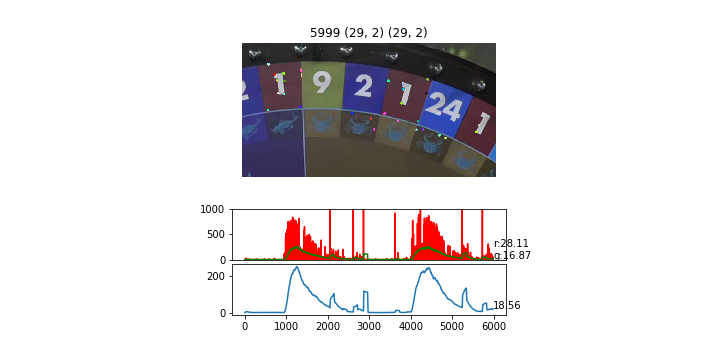

In [8]:
opticaltrack(mp4Dir2,10,6000,mode='blue')

#### Key observations
- Red spikes (>1000)
    - 1. half wheel + half lady
    - 2. top wheel only
    - 3. Back to whole wheel + full lady
- Extra individual spikes (not in group) may correspond to the lady movement, or black notice window shows up
- Stationary (avg area $\approx$ 15 or below)
- Continuous spikes correspond to the rotating wheel
- The zero crossing is due to the data compression, some key frames are re-used. So two consecutive frame can be identical.